TO DOS For data science project presentation
1. research question
2. background research
3. exploratory data analysis
4. what kind of model we are making

Background Information

Question: We aim to investigate whether data science techniques can denote countries sharing similar characteristics in terms of both food prices and nutritional value indices.

Signifcance: This research question addresses global challenges related to nutrition, food security, and sustainable development. The outcomes have the potential to guide the formulation of evidence-based policies, promoting better access to nutritious food and enhancing the well-being of the world.

Background: The Food Prices for Nutrition database integrates data from the International Comparison Program, food composition databases, and diverse nutritional sources, offering a comprehensive perspective on healthy diet economics across 176 countries. Our data science research project focuses on the pivotal variable "Percent of the population who cannot afford a healthy diet [CoHD_headcount]," aiming to assess the likelihood of food scarcity in specific nations. This metric serves as a key indicator for addressing global challenges related to nutrition accessibility and affordability.

In [214]:
# Load libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [215]:
Food_data = pd.read_csv(r"C:\Users\parke\OneDrive\food_data1.csv",encoding="latin")

In [216]:
## 1. Income Share by Top

import pandas as pd
top_df = pd.read_csv(r"C:\Users\parke\OneDrive\Income share by top 10%.csv")
df_top = pd.melt(top_df, id_vars=['Country Name', 'Country Code', 'Series Name', "Series Code"], var_name='Year', value_name='Income share held by highest 10%')
columns_to_drop = ['Country Code', 'Series Name', 'Series Code']
df_top = df_top.drop(columns=columns_to_drop) 
df_top.head()

,Country Name,Year,Income share held by highest 10%
0,Afghanistan,2017 [YR2017],..
1,Albania,2017 [YR2017],24.6
2,Algeria,2017 [YR2017],..
3,American Samoa,2017 [YR2017],..
4,Andorra,2017 [YR2017],..


In [217]:
## 2. Food production Index

import pandas as pd
foodp_df = pd.read_csv(r"C:\Users\parke\OneDrive\Food production index.csv")
df_fp = pd.melt(foodp_df, id_vars=['Country Name', 'Country Code', 'Series Name', "Series Code"], var_name='Year', value_name='Food production index (2014-2016 = 100)')
df_fp = df_fp.drop(columns=columns_to_drop)
df_fp.head()

,Country Name,Year,Food production index (2014-2016 = 100)
0,Afghanistan,2017 [YR2017],100.02
1,Albania,2017 [YR2017],103.9
2,Algeria,2017 [YR2017],102.87
3,American Samoa,2017 [YR2017],..
4,Andorra,2017 [YR2017],..


In [218]:
## 3. Income share by lowest 10

import pandas as pd
low_df = pd.read_csv(r"C:\Users\parke\OneDrive\Income share by lowest 10%.csv")
df_low = pd.melt(low_df, id_vars=['Country Name', 'Country Code', 'Series Name', "Series Code"], var_name='Year', value_name='Income share held by lowest 10%')
df_low = df_low.drop(columns=columns_to_drop)
df_low.head()

,Country Name,Year,Income share held by lowest 10%
0,Afghanistan,2017 [YR2017],..
1,Albania,2017 [YR2017],3.1
2,Algeria,2017 [YR2017],..
3,American Samoa,2017 [YR2017],..
4,Andorra,2017 [YR2017],..


In [ ]:
## 4. Poverty Line

import pandas as pd

poverty_line_df = pd.read_csv(r"C:\Users\parke\OneDrive\Poverty line.csv")
df_poverty_line = pd.melt(poverty_line_df, id_vars=['Country Name', 'Country Code', 'Series Name', "Series Code"], var_name='Year', value_name = 'Poverty headcount ratio at national poverty lines (% of population)')
df_poverty_line = df_poverty_line.drop(columns=columns_to_drop)#
df_poverty_line.head()

In [ ]:
## 5. Prevalence of Undernourishment

import pandas as pd
undernourishment_df = pd.read_csv(r"C:\Users\parke\OneDrive\Prevalence of undernourishment.csv")
df_undernourishment = pd.melt(undernourishment_df, id_vars=['Country Name', 'Country Code', 'Series Name', "Series Code"], var_name='Year', value_name='Prevalence of undernourishment (% of population)')
df_undernourishment = df_undernourishment.drop(columns=columns_to_drop)
df_undernourishment.head()


In [ ]:
## 6. Low Birth Weight of Babies

import pandas as pd
low_birth_weight_df = pd.read_csv(r"C:\Users\parke\OneDrive\low birth weight babies.csv")
df_low_birth_weight = pd.melt(low_birth_weight_df, id_vars=['Country Name', 'Country Code', 'Series Name', "Series Code"], var_name='Year', value_name='Low-birthweight babies (% of births)')
df_low_birth_weight = df_low_birth_weight.drop(columns=columns_to_drop)
df_low_birth_weight.head()


In [ ]:
## 7. Proportion of people living under median income

import pandas as pd
umedian_df = pd.read_csv(r"C:\Users\parke\OneDrive\Proportion of people living under median income.csv")
df_umedian = pd.melt(umedian_df, id_vars=['Country Name', 'Country Code', 'Series Name', "Series Code"], var_name='Year', value_name='Proportion of people living below 50 percent of median income (%)')
df_umedian = df_umedian.drop(columns=columns_to_drop)
df_umedian.head()

In [ ]:
## 8. Current Healthcare expenditure 

import pandas as pd
che_df = pd.read_csv(r"C:\Users\parke\OneDrive\Current healthcare expenditure.csv")
df_che = pd.melt(che_df, id_vars=['Country Name', 'Country Code', 'Series Name', "Series Code"], var_name='Year', value_name='Current health expenditure (% of GDP)')
df_che = df_che.drop(columns=columns_to_drop)
df_che.head()

In [ ]:
## 9. Crop Production 

import pandas as pd
crop_df = pd.read_csv(r"C:\Users\parke\OneDrive\Crop production.csv")
df_crop = pd.melt(crop_df, id_vars=['Country Name', 'Country Code', 'Series Name', "Series Code"], var_name='Year', value_name='Crop production index (2014-2016 = 100)')
df_crop = df_crop.drop(columns=columns_to_drop)
df_crop.head()

In [ ]:
#now its time to merge all our new data frames
# Merge DataFrames
merged_df = pd.merge(df_top, df_fp, on=['Country Name', 'Year'])
merged_df = pd.merge(merged_df, df_low, on=['Country Name', 'Year'])
merged_df = pd.merge(merged_df, df_poverty_line, on=['Country Name', 'Year'])
merged_df = pd.merge(merged_df, df_undernourishment, on=['Country Name', 'Year'])
merged_df = pd.merge(merged_df, df_low_birth_weight, on=['Country Name', 'Year'])
merged_df = pd.merge(merged_df, df_umedian, on=['Country Name', 'Year'])
merged_df = pd.merge(merged_df, df_che, on=['Country Name', 'Year'])
merged_df = pd.merge(merged_df, df_crop, on=['Country Name', 'Year'])
merged_df.head()

# BOOM

# doing food data last

In [ ]:
# Fix the year variables to match the main dataset
merged_df['Year'] = merged_df['Year'].str.extract(r'(\d{4})', expand=False)
merged_df.head()

In [ ]:
# rename Time column on food_data to Year
Food_data.rename(columns={'Time': 'Year'}, inplace=True)

Food_data.head()


In [ ]:
# Convert year to integer 
Food_data['Year'] = pd.to_numeric(Food_data['Year'], errors='coerce')
Food_data['Year'] = Food_data['Year'].fillna(0).astype(int)

Food_data.head()

# we need to remove the .0 at the ends i think thats whats messing everything up rn

In [ ]:
# Convert an integer column to string 
Food_data['Year'] = Food_data['Year'].astype(str)

Food_data.head()

In [ ]:
# Merge with original dataset
merged_df = pd.merge(Food_data, merged_df, on=['Country Name', 'Year'])

merged_df.head()

In [ ]:
#Drop columns that are not needed
columns_to_drop = ['Classification Name', 'Classification Code', 'Classification Code', 'Time Code',]
df_food = merged_df.drop(columns=columns_to_drop)
df_food.head() 

In [ ]:
#Need to drop .. values so that we can transform values to floats
df_food.replace('..', np.nan, inplace=True)
df_food.info()

In [ ]:
#We need to change the columns that are objects to strings and floats
columns_to_convert = df_food.columns[3:46]
df_food[columns_to_convert] = df_food[columns_to_convert].apply(pd.to_numeric, errors='coerce')


columns_to_convert2 = df_food.columns[0:2]
df_food[columns_to_convert2] = df_food[columns_to_convert2].astype(str)
df_food.info()

In [ ]:
# Group by the 'country' column and calculate the total number of NaN values for each country
nan_counts_per_country = df_food.groupby('Country Name').apply(lambda x: x.isnull().sum()).sum(axis=1)

# Replace 'nutrition_variable_column' with the actual name of the column you're interested in
column_of_interest = 'Percent of the population who cannot afford a healthy diet [CoHD_headcount]'

# Calculate the total number of NaN values for each country in the specified column
nan_counts_per_country = df_food.groupby('Country Name')[column_of_interest].apply(lambda x: x.isnull().sum())

# Create a new DataFrame with country names and their corresponding NaN counts for the specified column
nan_counts_df = pd.DataFrame({'Country Name': nan_counts_per_country.index, 'NaN_Counts': nan_counts_per_country.values})

# Sort the DataFrame based on NaN counts in descending order
sorted_nan_counts_df = nan_counts_df.sort_values(by='NaN_Counts', ascending=False)

# Display the DataFrame with NaN counts per country for the specified column
print(sorted_nan_counts_df.head(50))

# Get the list of countries with 5 or more NaN values
countries_to_drop = nan_counts_df[nan_counts_df['NaN_Counts'] >= 5]['Country Name']

# Drop rows with the specified countries from the original DataFrame
df_filtered = df_food[~df_food['Country Name'].isin(countries_to_drop)]

# Display the filtered DataFrame
print(df_filtered)

In [ ]:
#Lets look at the distribution of the target variable

#Histogram
import matplotlib.pyplot as plt
# Assuming 'target_variable' is the name of your target variable
plt.hist(df_filtered['Percent of the population who cannot afford a healthy diet [CoHD_headcount]'], bins=30, edgecolor='black')
plt.title('Histogram of Target Variable')
plt.xlabel('Percent of the population who cannot afford a healthy diet [CoHD_headcount]')
plt.ylabel('Frequency')
plt.show()
# looks like a lot of entries have low percentages of populations that cant afford healthy food. lets look at the lowest countries

In [ ]:
#There seems to be a lot of values at 0, lets see which countries fall in this bin. 
# Group by country and calculate statistics for the target variable
grouped_data = df_filtered.groupby('Country Name')['Percent of the population who cannot afford a healthy diet [CoHD_headcount]'].describe()
# Display the countries with the most values in the first bin
countries_in_first_bin = grouped_data[grouped_data['25%'] <= df_filtered['Percent of the population who cannot afford a healthy diet [CoHD_headcount]'].min()]
print(countries_in_first_bin)
#These countries have very high development indexes and thus would have very low values of percent of the population who cannot afford a healthy diet

In [ ]:
# Density plot
print(df_filtered['Percent of the population who cannot afford a healthy diet [CoHD_headcount]'].plot.density())

In [ ]:
# created a boxplot to find the median and max to see how we should bin the data
import matplotlib.pyplot as plt

column_to_plot = 'Percent of the population who cannot afford a healthy diet [CoHD_headcount]'

plt.figure(figsize=(8, 6))
plt.boxplot(df_filtered[column_to_plot].dropna(), vert=False)
plt.title(f'Box Plot of {column_to_plot}')
plt.xlabel('Column Values')
median_value = df_filtered[column_to_plot].median()
max_value = df_filtered[column_to_plot].max()
print(f"Median: {median_value}")
print(f"Maximum: {max_value}")
plt.show()


#df_filtered = df_filtered.loc[df_filtered['Percent of the population who cannot afford a healthy diet [CoHD_headcount]']< 80,:]  


In [249]:
#add this as a predictor instead of replacing the numeric version
# this predictor indicates the countries that have a high percentage of people who cant afford a healthy diet as a 1 and those who dont as a 0
df_food['CoHD_category'] = pd.cut(df_food['Percent of the population who cannot afford a healthy diet [CoHD_headcount]'], bins=[-1, 22.2, 97.8], labels=[0, 1])
#said that countries that are a concern are above median

Decision Trees and Probablity (method): We plan to use decision trees to understand critical features influencing the affordability of a healthy diet across countries. These decision trees will facilitate the identification of distinct clusters representing varying levels of food scarcity. Simultaneously using probability estimates to support our analysis by providing insights into the likelihood of specific nations encountering challenges related to nutrition accessibility.

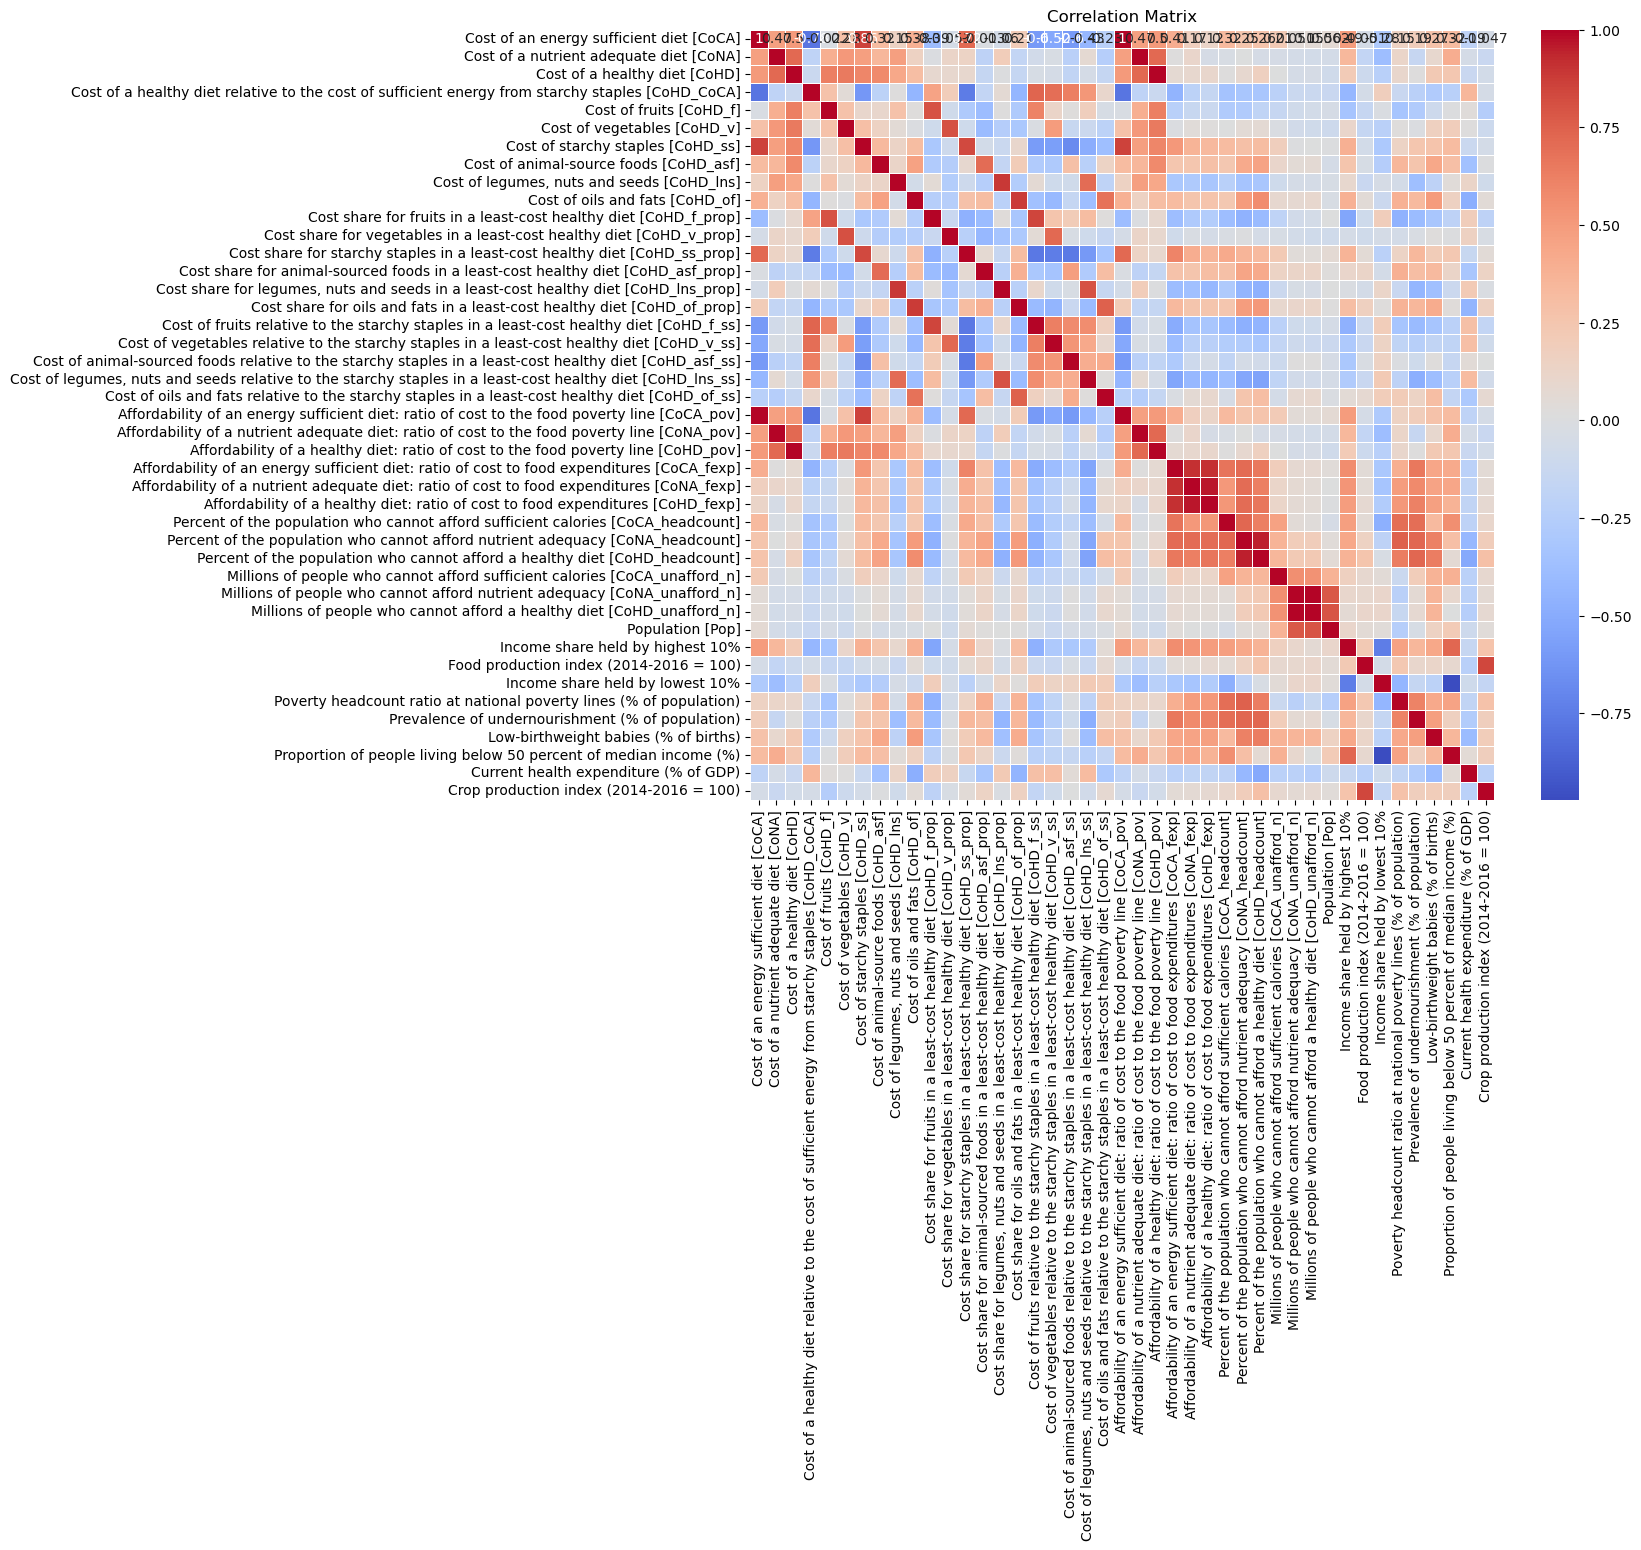

Correlations with Percent of the population who cannot afford a healthy diet [CoHD_headcount]:
Percent of the population who cannot afford a healthy diet [CoHD_headcount]                                   1.000000
Percent of the population who cannot afford nutrient adequacy [CoNA_headcount]                                0.948940
Prevalence of undernourishment (% of population)                                                              0.728391
Affordability of a healthy diet: ratio of cost to food expenditures [CoHD_fexp]                               0.661945
Affordability of an energy sufficient diet: ratio of cost to food expenditures [CoCA_fexp]                    0.654899
Poverty headcount ratio at national poverty lines (% of population)                                           0.636144
Low-birthweight babies (% of births)                                                                          0.630647
Percent of the population who cannot afford sufficient calories [CoCA_he

In [250]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


warnings.simplefilter(action='ignore', category=FutureWarning)

target_variable = 'Percent of the population who cannot afford a healthy diet [CoHD_headcount]'

# Select only numeric columns
numeric_df = df_filtered.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

# Focus on the correlation of other variables with the target variable
target_correlations = correlation_matrix[target_variable].sort_values(ascending=False)
print(f'Correlations with {target_variable}:\n{target_correlations}')
